# Create car-classifier based on synthetic car-images by Stable Diffusion



Stable Diffusionによる合成写真を使った判別モデルの作成

## 1. Ovreview of images by Stable Diffusion

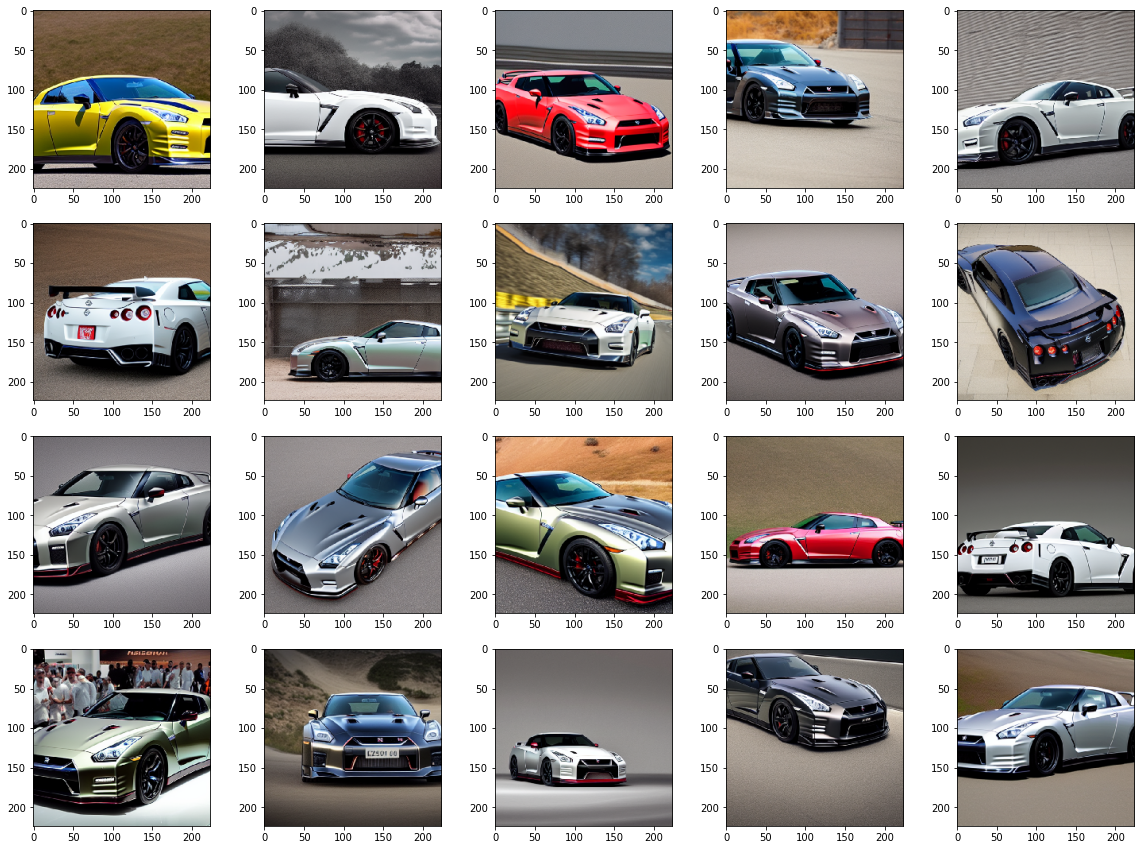

In [ ]:
# Read Images
prediction=(np.array(trainAim).astype(int))[0:20]
plt.figure(figsize=(20,15))

for i in range(len(prediction)):
    plt.subplot(4,5, i+1)
    plt.imshow(prediction[i]) 

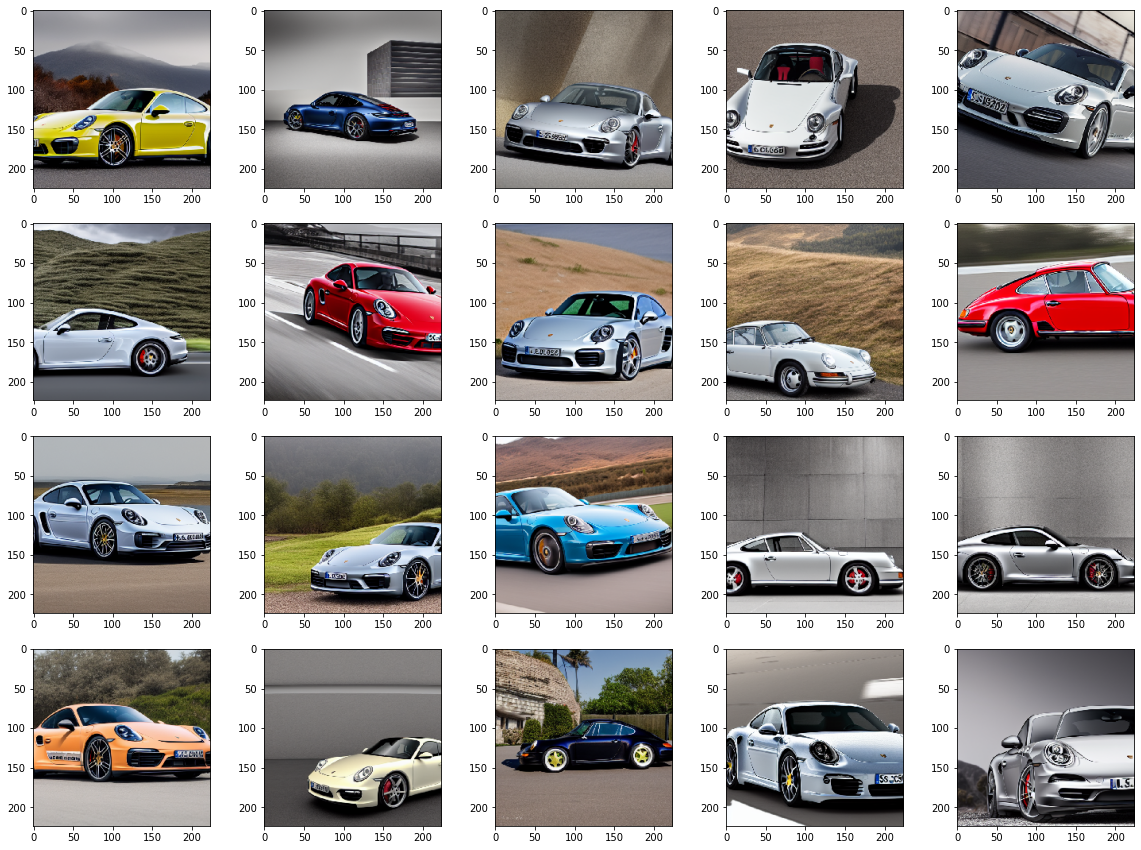

In [ ]:
# Read Images
prediction=(np.array(trainBim).astype(int))[0:20]
plt.figure(figsize=(20,15))

for i in range(len(prediction)):
    plt.subplot(4,5, i+1)
    plt.imshow(prediction[i]) 

##  2. Import library

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetB7, EfficientNetV2L
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import time
import glob
import json
import csv
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

from IPython.display import Image
%matplotlib inline

tf.__version__

'2.8.2'

## 3. Prepare dataset

In [ ]:
# load training data of A
images = glob.glob('GTR/train/*')
trainA=[]
for image in images:
    trainA.append(image)

# Read A Images
trainAim = []
#from keras.preprocessing import image
for images in trainA: 
    img = load_img(images, target_size=(224, 224))
    x = img_to_array(img)
    trainAim.append(x)
print(np.shape(trainAim))   

(100, 224, 224, 3)


In [ ]:
# load training data of B
images = glob.glob('POR/train/*')
trainB=[]
for image in images:
    trainB.append(image)

# Read B Images
trainBim = []
for images in trainB: 
    img = load_img(images, target_size=(224, 224))
    x = img_to_array(img)
    trainBim.append(x)
print(np.shape(trainBim))   

(100, 224, 224, 3)


In [ ]:
# load validation data of A
images = glob.glob('GTR/validation/*')
validationA=[]
for image in images:
    validationA.append(image)

# Read A Images
validationAim = []
for images in validationA: 
    img = load_img(images, target_size=(224, 224))
    x = img_to_array(img)
    validationAim.append(x)
print(np.shape(validationAim))   

(20, 224, 224, 3)


In [ ]:
# load validation data of B
images = glob.glob('POR/validation/*')
validationB=[]
for image in images:
    validationB.append(image)

# Read B Images
validationBim = []
for images in validationB: 
    img = load_img(images, target_size=(224, 224))
    x = img_to_array(img)
    validationBim.append(x)
print(np.shape(validationBim))   

(20, 224, 224, 3)


In [ ]:
#Create train data
X_train = np.vstack((trainAim,trainBim))
X_test= np.vstack((validationAim,validationBim))

print(np.shape(X_train))
print(np.shape(X_test))

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print(np.shape(X_train))
print(np.shape(X_test))

(200, 224, 224, 3)
(40, 224, 224, 3)
(200, 224, 224, 3)
(40, 224, 224, 3)


In [ ]:
#Create label data
n=2
y_train = np.hstack((np.zeros(len(X_train)//n), np.ones(len(X_train)//n)))
y_test =  np.hstack((np.zeros(len(X_test)//n), np.ones(len(X_test)//n)))

In [ ]:
print(np.shape(y_train))
print(np.shape(y_test ))

y_test

(200,)
(40,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [ ]:
y_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## 4. Create classifier by EfficientNet

In [ ]:
base_model = EfficientNetV2L(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output  #4d
print(np.shape(x))
x = GlobalAveragePooling2D()(x)  #2d
print(np.shape(x))
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# compile the model 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

t=time.time()

# train the model 
history=model.fit(X_train, y_train, validation_data=[X_test, y_test] , epochs=20, batch_size=32, shuffle=True)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Epoch 1/20
7/7 [==============================] - 34s 1s/step - loss: 0.6167 - accuracy: 0.6550 - val_loss: 0.5947 - val_accuracy: 0.6500
Epoch 2/20
7/7 [==============================] - 1s 182ms/step - loss: 0.4654 - accuracy: 0.8300 - val_loss: 0.4612 - val_accuracy: 0.8500
Epoch 3/20
7/7 [==============================] - 1s 181ms/step - loss: 0.3787 - accuracy: 0.8850 - val_loss: 0.4064 - val_accuracy: 0.8250
Epoch 4/20
7/7 [==============================] - 1s 183ms/step - loss: 0.3168 - accuracy: 0.9050 - val_loss: 0.3964 - val_accuracy: 0.8000
Epoch 5/20
7/7 [==============================] - 1s 184ms/step - loss: 0.3078 - accuracy: 0.8900 - val_loss: 0.3329 - val_accuracy: 0.9250
Epoch 6/20
7/7 [==============================] - 1s 198ms/step - loss: 0.2581 - accuracy: 0.9350 - val_loss: 0.3091 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 1s 183ms/step - loss: 0.2043 - accuracy: 0.9450 - val_loss: 0.2636 - val_accuracy: 0.9500
Epoch 8/20
7/7 [======

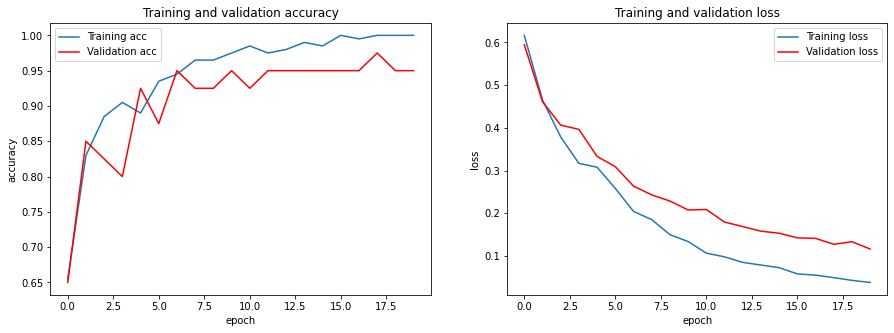

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, color="r", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color="r", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

## 5. Obtain predictions on new real images



In [ ]:
# load prediction data 
images = glob.glob('GTR/*')
pred=[]
for image in images:
    pred.append(image)

# Read prediction Images
prediction = []
for imm in pred: 
    img = load_img(imm, target_size=(224, 224))
    x = img_to_array(img)
    prediction.append(x)
print(np.shape(prediction))   

(20, 224, 224, 3)


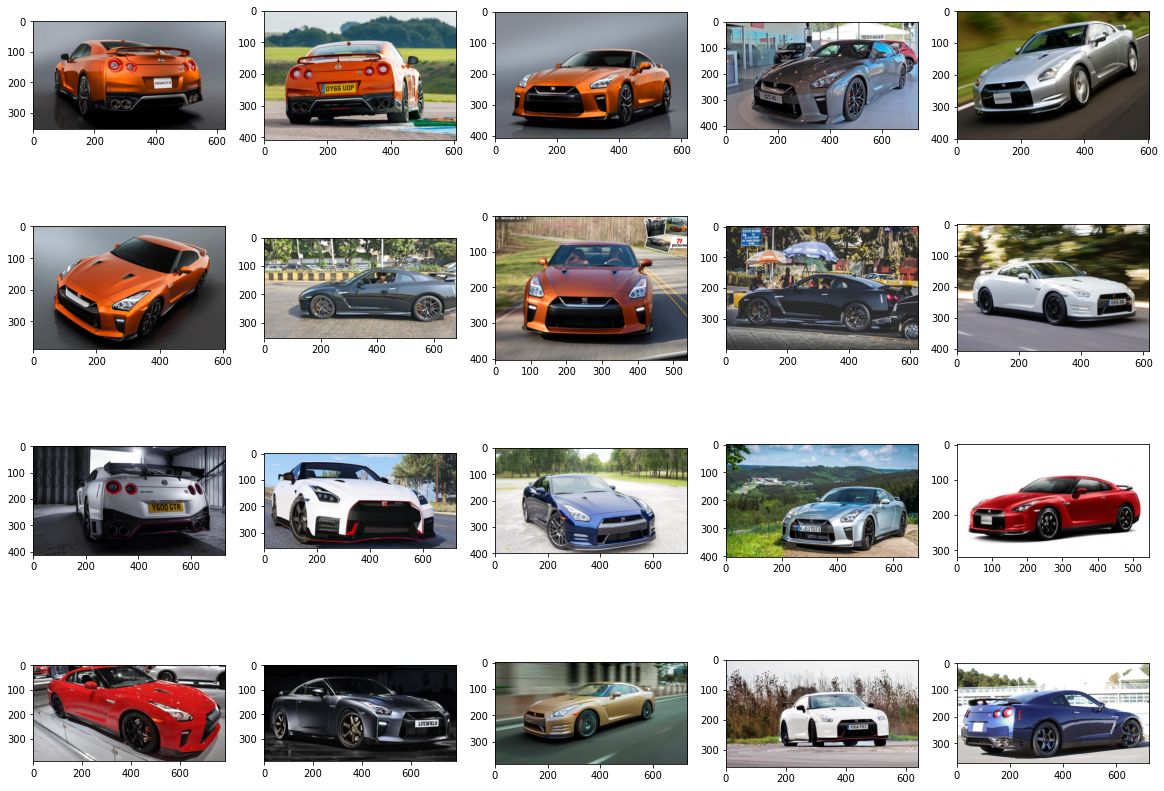

In [ ]:
# Read Images
imm = []
for image in pred :   
    im= mpimg.imread(image)
    imm.append(im)
plt.figure(figsize=(20,15))

for i in range(len(imm)):
    plt.subplot(4,5, i+1)
    plt.imshow(imm[i]) 

In [ ]:
predictionA1= np.array(prediction)
predictionA2 = preprocess_input(predictionA1)
predictionsA3 = model.predict(predictionA2)

print("accuracy:", 1-sum(np.argmax(predictionsA3, axis=1))/20)
print(np.argmax(predictionsA3, axis=1))


accuracy: 0.7
[0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0]


In [ ]:
# load prediction data 
images = glob.glob('POR/*')
pred=[]
for image in images:
    pred.append(image)

# Read prediction Images
prediction = []
for imm in pred: 
    img = load_img(imm, target_size=(224, 224))
    x = img_to_array(img)
    prediction.append(x)
print(np.shape(prediction))   

(20, 224, 224, 3)


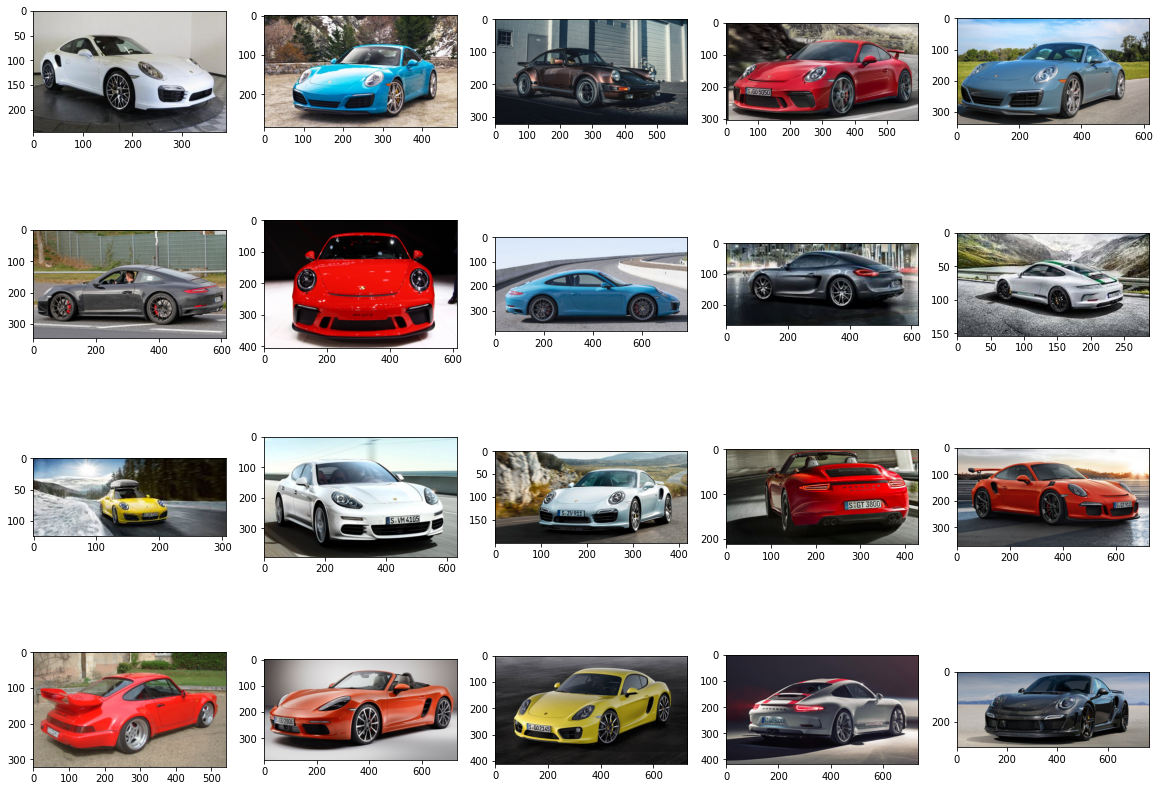

In [ ]:
# Read Images
imm = []
for image in pred :   
    im= mpimg.imread(image)
    imm.append(im)
plt.figure(figsize=(20,15))

for i in range(len(imm)):
    plt.subplot(4,5, i+1)
    plt.imshow(imm[i]) 

In [ ]:
predictionB1= np.array(prediction)
predictionB2 = preprocess_input(predictionB1)
predictionsB3 = model.predict(predictionB2)

print("accuracy:",sum(np.argmax(predictionsB3, axis=1))/20)
print(np.argmax(predictionsB3, axis=1))

accuracy: 0.9
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


#6. Check the accuracy

In [ ]:
#Create  data
n=2
X_test = np.vstack((predictionA2, predictionB2))
y_test =  np.hstack((np.zeros(len(X_test)//n), np.ones(len(X_test)//n)))

model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 78ms/step - loss: 0.4574 - accuracy: 0.8000


[0.45743417739868164, 0.800000011920929]

## others

In [ ]:
!nvidia-smi

Mon Sep 19 02:23:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model.summary()

(None, None, None, 1280)
(None, 1280)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['rescaling[0][0]']              
                                32)                     

### "Stable Diffusion" is being released under a Creative ML OpenRAIL-M license by Stability AI

   https://huggingface.co/spaces/CompVis/stable-diffusion-license
  

This code is solely for educational purpose. The code cannot be used for investments or busineeses in practice. Toshi Stats Co.,Ltd. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithm or ideas contained herein, or acting or refraining from acting as a result of such use. Toshi Stats Co.,Ltd. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on Toshi Stats Co.,Ltd. and me to correct any errors or defects in the codes and the software.¶